In [2]:
import pandas as pd
import numpy as np
import os
import sys
from  networkx import bipartite
sys.path.append('./../..')
sys.path.append('./..')
import glob
from tqdm import tqdm
import joblib
from joblib import Parallel, delayed
from pandarallel import pandarallel

pandarallel.initialize()
import re
import yaml
from collections import Counter
import pickle
import matplotlib.pyplot as plt
import seaborn as sns

id_col = 'PanjivaRecordID'
import networkx as nx
import operator
import collections
import argparse
from networkx.algorithms import community
CONFIG = None
DIR_LOC = None
CONFIG = None
CONFIG_FILE = 'config.yaml'
save_dir = None
id_col = 'PanjivaRecordID'
use_cols = None
freq_bound = None
attribute_columns = None
DIR = None
CUT_OFF = None

INFO: Pandarallel will run on 16 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [3]:
def set_up_config(_DIR=None):
    global DIR
    global CONFIG
    global CONFIG_FILE
    global use_cols
    global num_neg_samples
    global DATA_SOURCE
    global DIR_LOC
    global save_dir
    global id_col
    global attribute_columns

    DATA_SOURCE = './../generated_data_v1/'
    with open(CONFIG_FILE) as f:
        CONFIG = yaml.safe_load(f)

    if _DIR is not None:
        DIR = _DIR
        CONFIG['DIR'] = _DIR
    else:
        DIR = CONFIG['DIR']

    DIR_LOC = re.sub('[0-9]', '', DIR)
    DATA_SOURCE = os.path.join(DATA_SOURCE, DIR)
    save_dir = 'stage_2'
    save_dir = os.path.join(
        DATA_SOURCE,
        save_dir
    )

    if not os.path.exists(save_dir):
        os.mkdir(save_dir)

    use_cols = CONFIG[DIR]['use_cols']
    _cols = list(use_cols)
    _cols.remove(id_col)
    attribute_columns = list(sorted(_cols))
    return

In [3]:
# # ====================================
# #
# # ====================================
# def main(
#         DIR,
#         init_seed_count=10,
#         min_oh_nbr_count=2,
#         seed_degree_upper_bound=None
# ):
#     global DATA_SOURCE
#     global save_dir

In [4]:
DIR = 'us_import1'
set_up_config()

In [5]:
# =============================
# Main utility function
# =============================
def get_clusters(
    G, 
    comm, 
    max_pairs = 1, 
    max_1_nbrs = 2, 
    max_indirect_nbr_count = 3
):
    import operator 
    global CUT_OFF
    DEGREE_LB = 3
    DEGREE_UB = CUT_OFF
    
    DEGREE_LB = max(max_1_nbrs+1, DEGREE_LB)
    sg_obj = G.subgraph(comm)
    edgeWt_dict = {}
    for e in sg_obj.edges():
        edgeWt_dict[e] = sg_obj.get_edge_data(e[0],e[1])['weight']

    wt_lb = 2
    wt_ub = 15
    candidate_edges = {}

    for edge,wt in edgeWt_dict.items():
        if wt <= wt_lb or wt > wt_ub: continue 
        if  sg_obj.degree(e[0]) <= DEGREE_LB and sg_obj.degree(e[1]) <= DEGREE_LB :continue
        if  sg_obj.degree(e[0]) > DEGREE_UB or sg_obj.degree(e[1]) > DEGREE_UB :continue
        
    #     print(edge, wt ,(sg_obj.degree(e[0]),sg_obj.degree(e[1])))
        candidate_edges[edge] = wt * ((sg_obj.degree(e[0])+sg_obj.degree(e[1]))/2 )/ DEGREE_UB
    
    candidate_edges  = sorted(candidate_edges.items(),key = operator.itemgetter(1),reverse=True)
    # --------------------
#     np.random.shuffle(candidate_edges)
    count = 0
   
    marked_edges = []
    for edge_item in candidate_edges:
        
        node1 = edge_item[0][0]
        node2 = edge_item[0][1]
        
        count_2 = 0
        trials = 0
        target_nodes = []
        while count_2 < max_1_nbrs and trials < 10000:
            trials +=1
            n1_nbr = None
            n2_nbr = None
            try:
                n1_nbr_cand = [ _ for _ in sg_obj.neighbors(node1) if sg_obj.degree(_)> DEGREE_LB and sg_obj.degree(_) < DEGREE_UB and _!= node2 and _ not in target_nodes]
                n1_nbr = np.random.choice(n1_nbr_cand,1)[0]
                n2_nbr_cand = [_ for _ in sg_obj.neighbors(node2) if sg_obj.degree(_)> DEGREE_LB and  sg_obj.degree(_) < DEGREE_UB and  _!= node1 and _ not in target_nodes]
                n2_nbr = np.random.choice(n2_nbr_cand,1)[0]
            except: 
                continue
                
            if n1_nbr is  None or n2_nbr is  None:
                continue
            # find neighbors of n1_nbr and n2_nbr   
            try: 
                valid_nbrs = [
                    N for N in sg_obj.neighbors(n1_nbr) 
                    if N!= node1 and N not in list(sg_obj.neighbors(node2))  
                ]
                node1_nbr_2 = set(
                    np.random.choice(valid_nbrs, max_indirect_nbr_count, replace=True)
                )
                valid_nbrs = [
                    N for N in sg_obj.neighbors(n2_nbr) 
                    if N!= node2 and N not in list(sg_obj.neighbors(node1)) 
                ]
                node2_nbr_2 = set(
                    np.random.choice(valid_nbrs, max_indirect_nbr_count, replace=True)
                )
                print(' >>> ', node1, node2, n1_nbr, n2_nbr, node1_nbr_2, node2_nbr_2)
                count_2 += 1
                target_nodes.extend([node1,node2,n1_nbr,n2_nbr])
                target_nodes.extend(node1_nbr_2) 
                target_nodes.extend(node2_nbr_2)
                print('Target nodes :',len(set(target_nodes)))
            except: 
                continue
            
#         target_nodes.extend([node1,node2,n1_nbr,n2_nbr])
#         target_nodes.extend(node1_nbr_2)
#         target_nodes.extend(node2_nbr_2)
        if len(target_nodes) == 0: 
            continue
        new_subgraph = sg_obj.subgraph(target_nodes)
        print( 'Number of edges in new cluster subgraph', new_subgraph.number_of_edges())
        marked_edges.extend(new_subgraph.edges())
        count +=1
        if count >= max_pairs: 
            break
    print(len(marked_edges),marked_edges)      
    return marked_edges

In [6]:
def check_degree_distribution(graph_obj):
    degree_sequence = sorted([d for n, d in graph_obj.degree()], reverse=True)
    try:
        plt.title('Boxplot of degree')
        plt.boxplot(degree_sequence)
        plt.show()
    except:
        pass
    degreeCount = collections.Counter(degree_sequence)
    deg, cnt = zip(*degreeCount.items())
    try:
        fig, ax = plt.subplots()
        plt.bar(deg, cnt, width=0.80, color="b")
        plt.title("Degree Histogram")
        plt.ylabel("Count")
        plt.xlabel("Degree")
        plt.show()
    except:
        pass
    
def get_largest_component_subgraph(graph_obj):
    component_id = 0
    components = {}
    component_size_dict = {}

    for c in nx.connected_components(graph_obj):
        components[component_id] = c
        component_size_dict[component_id] = len(c)
        component_id += 1
    component_size_dict = sorted(component_size_dict.items(), key=operator.itemgetter(1), reverse=True)
    # Get the largest connected component
    max_component = components[component_size_dict[0][0]]
    subgraph = graph_obj.subgraph(max_component)
    return subgraph

In [7]:
def check(
    edges,
    ref_df,
    ANOM_PERC_THRESHOLD_LB,
    ANOM_PERC_THRESHOLD_UB
):
    
    record_count = 0
    for pair in edges:
        record_count +=len(ref_df.loc[(ref_df['ConsigneePanjivaID']== int(pair[0][1:]))&(ref_df['ShipperPanjivaID']==int(pair[1][1:]))])
    percentage = record_count/len(ref_df) *100
    print(' [  ======>  ]', percentage)

    if percentage >= ANOM_PERC_THRESHOLD_LB and percentage <= ANOM_PERC_THRESHOLD_UB: 
        return True,edges
    else:
        return False,None

In [8]:
def aux_gen_cluster(
    B2, 
    communities,
    max_pairs, 
    max_1_nbrs, 
    max_indirect_nbr_count,
    TOP_K_COMMUNITIES,
    ref_df,
    ANOM_PERC_THRESHOLD_LB,
    ANOM_PERC_THRESHOLD_UB
):
    print(' In aux_gen_cluster ...')
    all_marked = []
    for i in range(0,TOP_K_COMMUNITIES):
        edges = get_clusters_v2(
            B2, communities[i], max_pairs=max_pairs, max_1_nbrs=max_1_nbrs, max_indirect_nbr_count=max_indirect_nbr_count
        )
        all_marked.extend(edges)
    all_marked = [sorted(_) for _ in all_marked]
    valid, edges = check(
        all_marked,
        ref_df,
        ANOM_PERC_THRESHOLD_LB,
        ANOM_PERC_THRESHOLD_UB
    )
    if valid :
        return edges
    else:
        return None

In [9]:
# 
# =======================================
company_cols = ['ConsigneePanjivaID', 'ShipperPanjivaID']
company_col_abbr = {'C': 'ConsigneePanjivaID', 'S': 'ShipperPanjivaID'}
# -----------------------------------------------------------
# Before creating community out of nodes - this flag modulates - whether to prune high degree edges premptively
# setting to false  so that "cluster/community" is better captured
# ------------------------------------------------------------
PRE_PRUNE_BY_DEGREE = False
# -----------------------------------------------------------
# Total anomalies should be approximately between 5 to 10%
# -----------------------------------------------------------
ANOM_PERC_THRESHOLD_LB = 1.00
ANOM_PERC_THRESHOLD_UB = 6.25
# -----------------------------------------------------------
# generate anomalies from top k communities by size
TOP_K_COMMUNITIES = 20 
# ------------------------------------------------------------

df = pd.read_csv(
    os.path.join(DATA_SOURCE, 'train_data.csv'),
    low_memory=False,
    index_col=None
)
attributes = [ _ for _ in list(df.columns) if _ not in id_col]
df = df.drop_duplicates(subset = attributes)
df_subset = df[company_cols].groupby(
    company_cols).size().reset_index(
    name='count').sort_values(by='count', ascending=False)

df_subset['ConsigneePanjivaID'] = df_subset['ConsigneePanjivaID'].apply(
    lambda x: 'C' + str(x)
)

df_subset['ShipperPanjivaID'] = df_subset['ShipperPanjivaID'].apply(
    lambda x: 'S' + str(x)
)

# --------------------
# Create a bipartite graph
# --------------------
B = nx.Graph()
B.add_nodes_from(set(df_subset['ConsigneePanjivaID'].values), bipartite=0)
B.add_nodes_from(set(df_subset['ShipperPanjivaID'].values), bipartite=1)
edges = []
for i, j, k in zip(df_subset['ConsigneePanjivaID'].values,
                   df_subset['ShipperPanjivaID'].values,
                   df_subset['count'].values):
    edges.append((i, j, {'weight': k}))

B.add_edges_from(edges)
print(' IS the bipartite graph of Comapnies connected ? ', nx.is_connected(B))

 IS the bipartite graph of Comapnies connected ?  False


In [10]:
#  ---------------------------
# Remove nodes that are in 90th percentile of degree or more
# That is remove companies that are higly connected - since those are visible and deemed not suspicous/malacious
# ----------------------------
degree_sequence = sorted([d for n, d in B.degree()], reverse=True)
CUT_OFF = int(np.percentile(degree_sequence, 90))
print(' cut off degree ', CUT_OFF)

 cut off degree  7


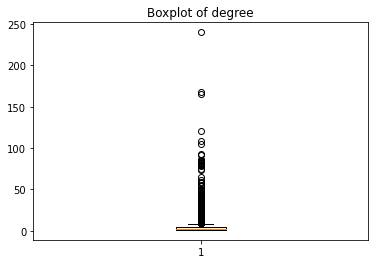

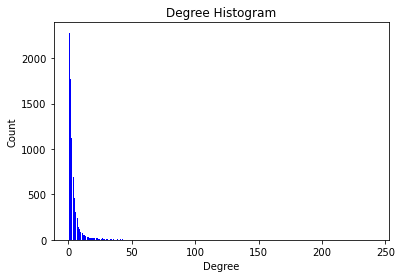

Number of nodes and edges 16836 7773


In [11]:
# ====================================================================================
# if PRE_PRUNE_BY_DEGREE == True
# Remove nodes of high degree beforehand
# ====================================================================================
if PRE_PRUNE_BY_DEGREE == True:
    nodes_to_remove = [n for n, d in B.degree() if d > CUT_OFF]
    B1 = nx.Graph(B)
    B1.remove_nodes_from(nodes_to_remove)
    print('Number of nodes and edges', B1.number_of_edges(), B1.number_of_nodes())
else:
    B1 = nx.Graph(B)

# =====================================================================================
# Largest connected component in the bipartite graph , after pruning high degree nodes   
# ======================================================================================
B2 = get_largest_component_subgraph(B1)
check_degree_distribution(B2)
print('Number of nodes and edges', B2.number_of_edges(), B2.number_of_nodes())
# ==========================================
# Parititon the graph into communities 
# ==========================================

communities = community.greedy_modularity_communities(B2)
df_test = pd.read_csv(
    os.path.join(DATA_SOURCE, 'test_data.csv'),
    low_memory=False,
    index_col=None
)
df_test= df_test.drop_duplicates(subset=attribute_columns)

import multiprocessing as mp

In [12]:
edge_list = []
found = False
while True:

    c = aux_gen_cluster(
        B2,
        communities,
        max_pairs=4, max_1_nbrs=5, max_indirect_nbr_count=1,
        TOP_K_COMMUNITIES=TOP_K_COMMUNITIES,
        ref_df=df_test,
        ANOM_PERC_THRESHOLD_LB=ANOM_PERC_THRESHOLD_LB,
        ANOM_PERC_THRESHOLD_UB=ANOM_PERC_THRESHOLD_UB
    )

    if c is not None:
        edge_list = c
        found = True
        break

return edge_list

 In aux_gen_cluster ...


NameError: name 'get_clusters_v2' is not defined

In [46]:
# =============================
# Main utility function
# =============================
def get_clusters_v2(
    G, 
    comm, 
    max_pairs = 1, 
    max_1_nbrs = 2, 
    max_indirect_nbr_count = 3
):
    import operator 
    global CUT_OFF
    
    DEGREE_LB = 3
    DEGREE_UB = CUT_OFF
    
    DEGREE_LB = max(max_1_nbrs+1, DEGREE_LB)
    sg_obj = G.subgraph(comm)
    sg_obj = nx.Graph(sg_obj)
    print(sg_obj.number_of_edges(),sg_obj.number_of_nodes())
    edgeWt_dict = {}
    for e in sg_obj.edges():
        edgeWt_dict[e] = sg_obj.get_edge_data(e[0],e[1])['weight']

    wt_lb = 2
    wt_ub = 15
    candidate_edges = {}
    for edge,wt in edgeWt_dict.items():
        print(wt, sg_obj.degree(e[0]),sg_obj.degree(e[1]) )
        if wt < wt_lb or wt > wt_ub: continue 
        if  sg_obj.degree(e[0]) < DEGREE_LB and sg_obj.degree(e[1]) < DEGREE_LB : continue
        if  sg_obj.degree(e[0]) > DEGREE_UB and sg_obj.degree(e[1]) > DEGREE_UB :continue
        candidate_edges[edge] = wt * ((sg_obj.degree(e[0])+sg_obj.degree(e[1]))/2)/ DEGREE_UB
     
    print(len(candidate_edges))
    candidate_edges  = sorted(
        candidate_edges.items(),
        key = operator.itemgetter(1), 
        reverse=True
    )
    marked_edges = []
    count = 0
    for edge_item in candidate_edges:
      
        node1 = edge_item[0][0]
        node2 = edge_item[0][1]
        target_nodes =[]
        # Find the closest neighbors of each  
        node1_nbr_cand = {}
        for N in sg_obj.neighbors(node1):
            if sg_obj.degree(N)< DEGREE_LB or sg_obj.degree(N)>DEGREE_UB or N == node2: continue
            wt = sg_obj.get_edge_data(node1,N)['weight']
            if wt <= wt_lb or wt > wt_ub: continue
            node1_nbr_cand[N]=wt
            
        node2_nbr_cand = {}
        for N in sg_obj.neighbors(node2):
            if sg_obj.degree(N)< DEGREE_LB or sg_obj.degree(N) > DEGREE_UB or N == node1: continue
            wt = sg_obj.get_edge_data(node2,N)['weight']
            if wt <= wt_lb or wt > wt_ub: continue      
            node2_nbr_cand[N]=wt  
        
        node1_nbr_cand = sorted(
            node1_nbr_cand.items(),
            key = operator.itemgetter(1), 
            reverse=True
        )
        
        node2_nbr_cand = sorted(
            node2_nbr_cand.items(),
            key = operator.itemgetter(1), 
            reverse=True
        )
        
        # These are neighbors of the seed nodes from the edge
        node2_nbrs = [_[0]  for _ in node2_nbr_cand[:max_1_nbrs]]
        node1_nbrs = [_[0]  for _ in node1_nbr_cand[:max_1_nbrs]]
        print( node1, node2, node1_nbrs, node2_nbrs)
        
#         try :
#             if len(n1_nbr_cand) < max_1_nbrs: continue
#             n1_nbr = n1_nbr_cand 
#             n1_nbr = np.random.choice(n1_nbr_cand,2)
#         except :
#             pass
        
#         n2_nbr_cand = [ _ for _ in sg_obj.neighbors(node2) if sg_obj.degree(_)> DEGREE_LB and  sg_obj.degree(_) < DEGREE_UB and _!= node1 and _ not in target_nodes]
#         try :
#             if len(n2_nbr_cand) < max_1_nbrs: continue
#             n2_nbr = n2_nbr_cand 
#             n2_nbr = np.random.choice(n2_nbr_cand, 2*5,True)
#         except :
#             continue
        
        target_nodes = [node1,node2]
        target_nodes.extend(node2_nbrs)
        target_nodes.extend(node1_nbrs)
         
        new_subgraph = sg_obj.subgraph(target_nodes)
        print( 'Number of edges in new cluster subgraph', new_subgraph.number_of_edges())
        marked_edges.extend(new_subgraph.edges())
        count +=1
        if count >= max_pairs: 
            break
    print(len(marked_edges),marked_edges)      
    return marked_edges
#         # -----------------
#         # New subgraph
#         # -----------------
#         new_sg = sg_obj.subgraph(new_node_list) 
        
        
        

In [150]:
def get_clusters_v3(
    G, 
    comm, 
    max_pairs = 2,
    grow_size = 3,
    grow_steps= 2
):
    import operator 
    global CUT_OFF
    
    DEGREE_LB = 3
    DEGREE_UB = CUT_OFF+2
    
    DEGREE_LB = max(grow_size, DEGREE_LB)
#     sg_obj = G.subgraph(comm)
    sg_obj = nx.Graph(G)
    print(sg_obj.number_of_edges(),sg_obj.number_of_nodes())
    edgeWt_dict = {}
    for e in sg_obj.edges():
        edgeWt_dict[e] = sg_obj.get_edge_data(e[0],e[1])['weight']

    wt_lb = 2
    wt_ub = 15
    candidate_edges = {}
    for edge,wt in edgeWt_dict.items():
        if wt < wt_lb or wt > wt_ub: continue 
        if  sg_obj.degree(e[0]) < DEGREE_LB and sg_obj.degree(e[1]) < DEGREE_LB : continue
        if  sg_obj.degree(e[0]) > DEGREE_UB and sg_obj.degree(e[1]) > DEGREE_UB :continue
        candidate_edges[edge] = wt * ((sg_obj.degree(e[0])+sg_obj.degree(e[1]))/2)/ DEGREE_UB
        
    print(' >', len(candidate_edges))
    candidate_edges  = sorted(
        candidate_edges.items(),
        key = operator.itemgetter(1), 
        reverse=True
    )
    marked_edges = []
    count = 0
    for edge_item in candidate_edges:
        flag = True
        seed1 = edge_item[0][0]
        seed2 = edge_item[0][1]   
        target_nodes = [seed1,seed2]
        expansion_dict = { 1: [seed1,seed2] }
        for g in range(2, grow_steps + 1):
            expansion_dict[g] = []
            for t in expansion_dict[g-1]:
                t_nbrs = []
                for N in sg_obj.neighbors(t):
                    if sg_obj.degree(N)< DEGREE_LB or sg_obj.degree(N)>DEGREE_UB or N == t: 
                        continue
                    wt = sg_obj.get_edge_data(t,N)['weight']
                    if wt <= wt_lb or wt > wt_ub: continue
                    t_nbrs.append(N)
                try: 
                    t_nbrs = np.random.choice(t_nbrs,grow_size,replace=True)
                    target_nodes.extend(t_nbrs)
                except: 
                    flag = False
                    continue
                expansion_dict[g].extend(set(t_nbrs))
        new_subgraph = sg_obj.subgraph(target_nodes)
        
        if new_subgraph.number_of_edges() > 8 and flag : 
            print( 'Number of edges in new cluster subgraph', new_subgraph.number_of_edges())
            count +=1
            marked_edges.extend(new_subgraph.edges())
            
            print(marked_edges)
            marked_edges = list(marked_edges)
        if count >= max_pairs: 
            break
    return marked_edges  

In [151]:
edges = get_clusters_v3(
    B, None, max_pairs= 25,  grow_size = 3, grow_steps= 5
)

18197 10012
 > 9320
Number of edges in new cluster subgraph 9
[('C1263', 'S3711'), ('C1263', 'S2237'), ('C1598', 'S3184'), ('C1598', 'S1264'), ('C1598', 'S1984'), ('S3711', 'C4246'), ('S3551', 'C4246'), ('C2835', 'S1264'), ('C4246', 'S1264')]
Number of edges in new cluster subgraph 14
[('C1263', 'S3711'), ('C1263', 'S2237'), ('C1598', 'S3184'), ('C1598', 'S1264'), ('C1598', 'S1984'), ('S3711', 'C4246'), ('S3551', 'C4246'), ('C2835', 'S1264'), ('C4246', 'S1264'), ('C3204', 'S2789'), ('S257', 'C1649'), ('C3611', 'S2789'), ('C3611', 'S819'), ('C3611', 'S5460'), ('C3611', 'S5243'), ('C3611', 'S4322'), ('C1884', 'S4322'), ('C4126', 'S2789'), ('C4126', 'S5460'), ('S637', 'C2543'), ('S5460', 'C1649'), ('S5243', 'C2543'), ('S4322', 'C409')]
Number of edges in new cluster subgraph 10
[('C1263', 'S3711'), ('C1263', 'S2237'), ('C1598', 'S3184'), ('C1598', 'S1264'), ('C1598', 'S1984'), ('S3711', 'C4246'), ('S3551', 'C4246'), ('C2835', 'S1264'), ('C4246', 'S1264'), ('C3204', 'S2789'), ('S257', 'C16

In [153]:
edges = ['_'.join(sorted(_)) for _ in edges]


In [154]:
len(set(edges))

120

In [126]:
ref_df = df_test

In [152]:
record_count = 0
for pair in edges:
    record_count +=len(ref_df.loc[(ref_df['ConsigneePanjivaID']== int(pair[0][1:]))&(ref_df['ShipperPanjivaID']==int(pair[1][1:]))])
percentage = record_count/len(ref_df) *100
print(' [  ======>  ]', percentage)

 [  ======>  ] 1.1213102470093934


In [ ]:



# node_pairs = [ [ int(_[1:]) for _ in pair] for pair in all_marked]


# df_test = pd.read_csv(
#     os.path.join(DATA_SOURCE, 'test_data.csv'),
#     low_memory=False,
#     index_col=None
# )
# df_test= df_test.drop_duplicates(subset=attribute_columns)

# # set_C = []
# # set_S = []
# # for a in all_marked:
# #     if a[0] == 'S' : set_S.append(int(a[1:]))
# #     else: set_C.append(int(a[1:]))
        
        

# l = 0
# for pair in node_pairs:
#     l +=len(df_test.loc[(df_test['ConsigneePanjivaID']== pair[0])|(df_test['ShipperPanjivaID']==pair[1])])
# 2*l/len(df_test)

# len(df_test)

# 2000/37000

# top_k_community_count = 12
# pad = 0
# set_C = set()
# set_S = set()

# for comm in communities[pad:top_k_community_count+pad]:
#     sg = B2.subgraph(comm)
#     print('Number of nodes and edges[Subgraph]', sg.number_of_edges(), sg.number_of_nodes())
#     seed_nodes, seed_nbrs, seed_1_nbrs = process_subgraph(
#        sg
#     )
#     if len(seed_1_nbrs['C']) == 0 or len(seed_1_nbrs['S']) == 0: continue
# #     if len(seed_nbrs['C']) == 0 or len(seed_nbrs['S']) == 0: continue
#     key = 'C'
# #     set_C = set_C.union(set(seed_1_nbrs[key]))
#     set_C =set_C.union(set(seed_nbrs[key]))
#     set_C =set_C.union(set(seed_nodes[key]))
#     key = 'S'
# #     set_S = set_S.union(set(seed_1_nbrs[key]))
#     set_S = set_S.union(set(seed_nbrs[key]))
#     set_S = set_S.union(set(seed_nodes[key]))
    
    
    
    
    



# len(set_S),len(set_C)

# set_S = [ int(_[1:]) for  _ in set_S]
# set_C = [ int(_[1:]) for  _ in set_C]

# df.loc[(df['ConsigneePanjivaID'].isin(set_C))|(df['ShipperPanjivaID'].isin(set_S))]

# print('Number of nodes and edges', subgraph.number_of_edges(), subgraph.number_of_nodes())
# degree_sequence = sorted([d for n, d in subgraph.degree()], reverse=True)  # degree sequence
# degreeCount = collections.Counter(degree_sequence)
# deg, cnt = zip(*degreeCount.items())
# try:
#     fig, ax = plt.subplots()
#     plt.bar(deg, cnt, width=0.80, color="b")
#     plt.title("Degree Histogram")
#     plt.ylabel("Count")
#     plt.xlabel("Degree")
#     plt.show()
# except:
#     pass

# subgraph.number_of_edges(), subgraph.number_of_nodes(),subgraph.is_directed()


# B1 = get_largest_component_subgraph(subgraph)
# print('Number of nodes and edges', B1.number_of_edges(), B1.number_of_nodes())


# degrees = [d for n, d in subgraph.degree()]
# if seed_degree_upper_bound is None:
#     seed_degree_upper_bound = np.percentile(degrees, 75)

seed_degree_upper_bound

# -----------------------------
# Select the set of seeds
# -----------------------------
# Per type seed count

min_seed_degree = min_oh_nbr_count + 1
max_seed_degree = min_seed_degree + 1
print(' Min, max of seed degree', min_seed_degree, max_seed_degree)

node_dict = {}
for n in subgraph.nodes():
    _type = n[0]
    if _type in node_dict.keys():
        node_dict[_type].append(n)
    else:
        node_dict[_type] = [n]

seed_dict = {}
for _type, _list in node_dict.items():
    _list = [n for n in _list if subgraph.degree(n) >= min_seed_degree and subgraph.degree(n) <= max_seed_degree]
    seed_dict[_type] = np.random.choice(
        _list, 
        replace=False, 
        size=init_seed_count
    )

In [ ]:
seed_dict

In [ ]:
# ==================================================
# Find one hop neighbors of these seeds
# Sample from them - to be labelled as "positive"
# ==================================================



In [ ]:
seed_bipartite_nbrs = {'C': [], 'S': []}
for _type in ('C', 'S'):
    nbrs = []
    for n in seed_dict[_type]:
        nbrs.extend([n1 for n1 in subgraph.neighbors(n) if subgraph.degree(n1) <= seed_degree_upper_bound])
    nbrs = list(set(nbrs))
    # get C or S
    n_type = nbrs[0][0]
    seed_bipartite_nbrs[n_type] = nbrs

In [ ]:
C_onehop_nbrs = []
for nc in seed_dict['C']:
    ohn = find_one_hop_neigbbor(
        subgraph, nc, seed_degree_upper_bound, exclsion_list= list(seed_dict['S']) + list(seed_bipartite_nbrs['S']), count=min_oh_nbr_count
    )
    C_onehop_nbrs.extend(ohn)

S_onehop_nbrs = []
for nc in seed_dict['S']:
    ohn = find_one_hop_neigbbor(
        subgraph, nc, seed_degree_upper_bound, exclsion_list=list(seed_dict['C'])  + list(seed_bipartite_nbrs['C']), count=min_oh_nbr_count)
    S_onehop_nbrs.extend(ohn)

In [ ]:
seed_onehop_nbrs = {
    'S': S_onehop_nbrs,
    'C': C_onehop_nbrs
}

In [ ]:
len(S_onehop_nbrs),len(C_onehop_nbrs)

In [ ]:
# ==================================
# Accumulate the nodes of each type
# These are the ones that are "Bad"
# ==================================
target_nodes_dict = {_: [] for _ in company_col_abbr.values()}
for _type, _list in seed_dict.items():
    _type = company_col_abbr[_type]
    target_nodes_dict[_type].extend(_list)

for _type, _list in seed_bipartite_nbrs.items():
    _type = company_col_abbr[_type]
    target_nodes_dict[_type].extend(list())

for _type, _list in seed_onehop_nbrs.items():
    _type = company_col_abbr[_type]
    target_nodes_dict[_type].extend(_list)

for _type in target_nodes_dict.keys():
    target_nodes_dict[_type] = set([int(_[1:]) for _ in target_nodes_dict[_type]])
    print(len(target_nodes_dict[_type]))
    
    
# save_file = os.path.join(save_dir, 'seed_nodes.pkl')
# Save in a pickle file
#     with open(save_file, "wb") as fh:
#         pickle.dump(target_nodes_dict, fh, pickle.HIGHEST_PROTOCOL)

# ============================
# return target_nodes_dict

In [ ]:
parser = argparse.ArgumentParser()
parser.add_argument(
    '--DIR', choices=['us_import1', 'us_import2', 'us_import3'],
    default='us_import1'
)

args = parser.parse_args()
DIR = args.DIR
set_up_config(
    DIR
)
target_nodes_dict = main(
    DIR,
    init_seed_count=25,
    min_oh_nbr_count=3
)